## imports

In [1]:
import numpy as np
import pandas as pd

import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tqdm import tqdm

## functions

In [2]:
def gauss(v, ro, sigma):
    return ro / (np.sqrt(np.pi * 2) * sigma) * np.exp(- v ** 2 / (2 * sigma ** 2))

In [3]:
def calculate_mode_part(v, gamma, k, eta, g_ini):
    g = - eta / (v - 1j * gamma / k)
    g_complex = - 1 /(v - 1j * gamma / k)
    C = integrate.simps(eta * (v ** 2 - gamma ** 2 / k ** 2) / (v ** 2 + gamma ** 2 / k ** 2) ** 2, x=v) + \
        1j * integrate.simps(eta * (2 * v * gamma / k) / (v ** 2 + gamma ** 2 / k ** 2) ** 2, x=v)

    a = integrate.simps(g_complex * g_ini, x = v) / C
    #print(a)
    return a * g

In [4]:
def dfdt(t, y, v):
    return 1j * k * (- v * y - 4 * np.pi * G * F0_dev / k ** 2 * integrate.simps(y, x=v))

## parameters and grids

In [5]:
ro0 = 1
sigma0 = 0.5

ro1 = 1
sigma1 = 1e-1
G = 1

In [6]:
uv = np.linspace(-np.sqrt(5), np.sqrt(5), 1001)
v = np.sign(uv) * uv ** 2

time = np.linspace(0, 5, 100001)
t_step = time[1] - time[0]

In [7]:
aper_mode = pd.read_csv('hsm_aper_mode.dat', delimiter='\s+', names=['(k/k_j)**2', 'gamma'])

In [8]:
index = 455

k = np.sqrt(aper_mode.iloc[index, 0] * 4 * np.pi * G * ro0 / sigma0 ** 2)
gamma = aper_mode.iloc[index, 1] * G * ro0
blue_line = -3.7481724 #-1.9039562

## calculate initial condition

In [9]:
F0_dev = gauss(v, ro0, sigma0) * (- v / sigma0 ** 2)

In [10]:
g_ini = gauss(v, ro1, sigma1)

In [11]:
eta = 4 * np.pi * G / k ** 2 * F0_dev

In [12]:
plus = calculate_mode_part(v, gamma, k, eta, g_ini)
minus = calculate_mode_part(v, -gamma, k, eta, g_ini)

In [13]:
f_ini = g_ini - minus - plus

## linearized Boltzmann equation

### hand-made solution

In [14]:
f = []
f_next = f_ini

for t in time:
    f.append(f_next)
    f_next = f_next + t_step * 1j * k * (- v * f_next - 
                                         4 * np.pi * G * F0_dev / k ** 2 * 
                                            integrate.simps(f_next, x=v))
    

In [15]:
density_hm = -integrate.simps(np.real(np.array(f)), x=v, axis=1)

### scipy solution

In [16]:
diff = integrate.solve_ivp(lambda t, y: dfdt(t, y, v), (0, time[-1]), f_ini, t_eval=time, rtol=1e-5)

In [17]:
density_scipy = -integrate.simps(np.real(diff.y.T), x=v, axis=1)

## plots

Text(0, 0.5, 'density')

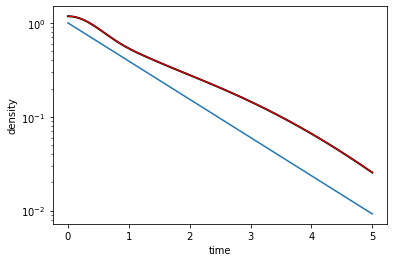

In [22]:
plt.plot(time, density_hm, lw=2, c='black')
plt.plot(diff.t, density_scipy, lw=1, c='red')

plt.plot(time, np.exp(blue_line * np.array(time)/4))
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('density')

In [19]:
#d400 = -integrate.simps(np.real(diff.y.T), x=v, axis=1)

In [20]:
# df_results = pd.DataFrame(data={'t': time, 'density_400': d400, 'density_455': d455})
# df_results.to_csv('densities.dat', sep=' ', index=False)